<a href="https://colab.research.google.com/github/ArupDukeBanerjee/credit-card-default/blob/main/Credit_Card_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.7 MB/s 


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.4 MB/s 


In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import math

# Feature Selection
from sklearn.feature_selection import mutual_info_classif

# model building
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# Optimizer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, pyll, space_eval


# model evaluation
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import shap

from pandas.api.types import is_numeric_dtype

from Features import *
from AttributeRelevance import *


In [ ]:
data = pd.read_csv('UCI_Credit_card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
data.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

### Checking missing values

In [ ]:
data.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [ ]:
df = data.copy()
df.drop('ID', axis=1, inplace = True)
df.rename(columns={'default payment next month':'default'}, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df = df.astype({'SEX': 'object',
'EDUCATION': 'object',
'MARRIAGE': 'object',
'PAY_0': 'object',
'PAY_2': 'object',
'PAY_3': 'object',
'PAY_4': 'object',
'PAY_5': 'object',
'PAY_6': 'object',
})
df.dtypes

LIMIT_BAL     int64
SEX          object
EDUCATION    object
MARRIAGE     object
AGE           int64
PAY_0        object
PAY_2        object
PAY_3        object
PAY_4        object
PAY_5        object
PAY_6        object
BILL_AMT1     int64
BILL_AMT2     int64
BILL_AMT3     int64
BILL_AMT4     int64
BILL_AMT5     int64
BILL_AMT6     int64
PAY_AMT1      int64
PAY_AMT2      int64
PAY_AMT3      int64
PAY_AMT4      int64
PAY_AMT5      int64
PAY_AMT6      int64
default       int64
dtype: object

In [ ]:
y = df['default']
X = df.drop('default', axis=1)

### Checking basic statistics

In [ ]:
X.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [ ]:
X.describe(include = 'object')

,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,2,7,4,11,11,11,11,10,10
top,2,2,2,0,0,0,0,0,0
freq,18112,14030,15964,14737,15730,15764,16455,16947,16286


In [ ]:
y.value_counts()/len(y)*100

0    77.88
1    22.12
Name: default, dtype: float64

### target values have decent percentage to be modeled.. we don't not need to apply imbalance treatment

#                               *Feature Analysis*

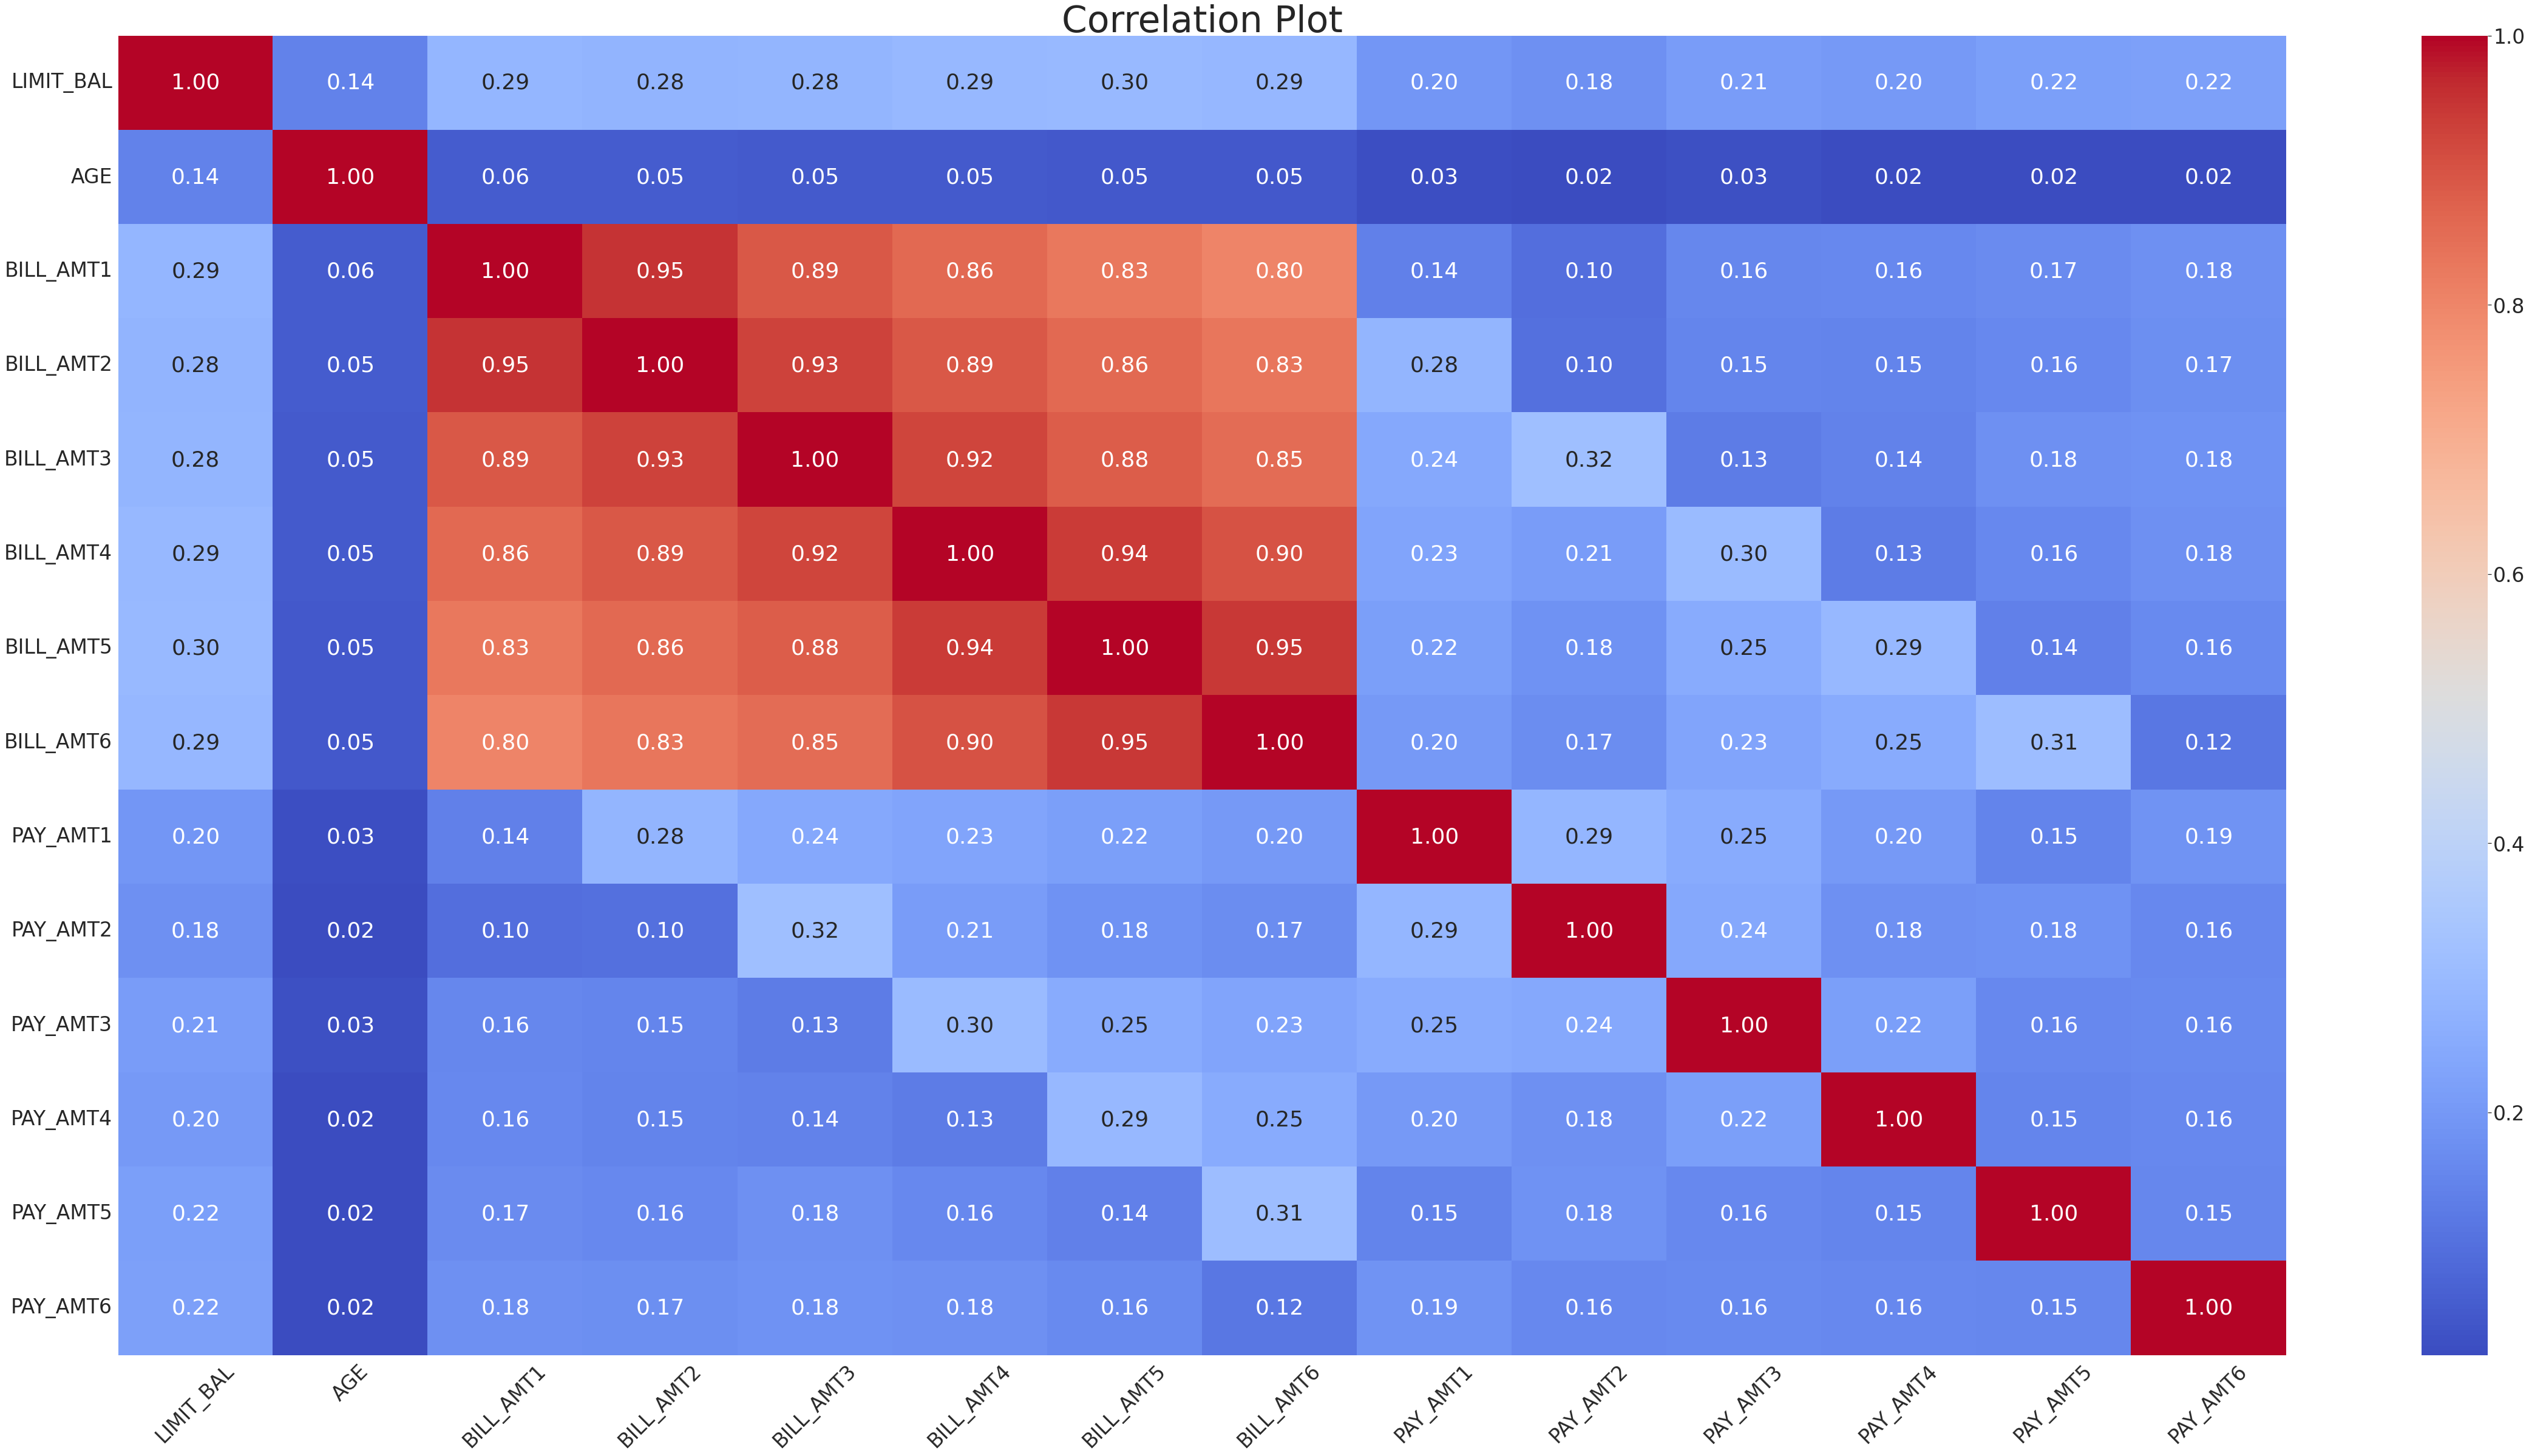

In [ ]:
fig, ax = plt.subplots(figsize=(80,40))
sns.set(font_scale = 3)
p = sns.heatmap(X.select_dtypes(exclude = ['object']).corr(), annot = True, fmt = ".2f", cmap = "coolwarm", ax=ax)
p.set_xlabel("", fontsize = 20)
p.set_ylabel("", fontsize = 20)
p.set_title("Correlation Plot", fontsize = 60)
plt.xticks(rotation = 45)
plt.show()

### BILL_AMT variables are highly correlated
### dependant featues can be dropped after careful consideration of IV/Mutual Information and VIF (Variance Inflation factor).

### Their presence may increase the standard error in parameter estimates of logistic regression, as a consequence parameter estimates will be unstable, confidence intervals will be larger.

#### Linear classifier like logistic regression has its paramter estimates usng MLE, and the estimates asymtotically follows normal distribution

---



## Checking Outliers

In [ ]:
df_out=df.copy()
df_out.drop('default', axis=1,inplace=True)

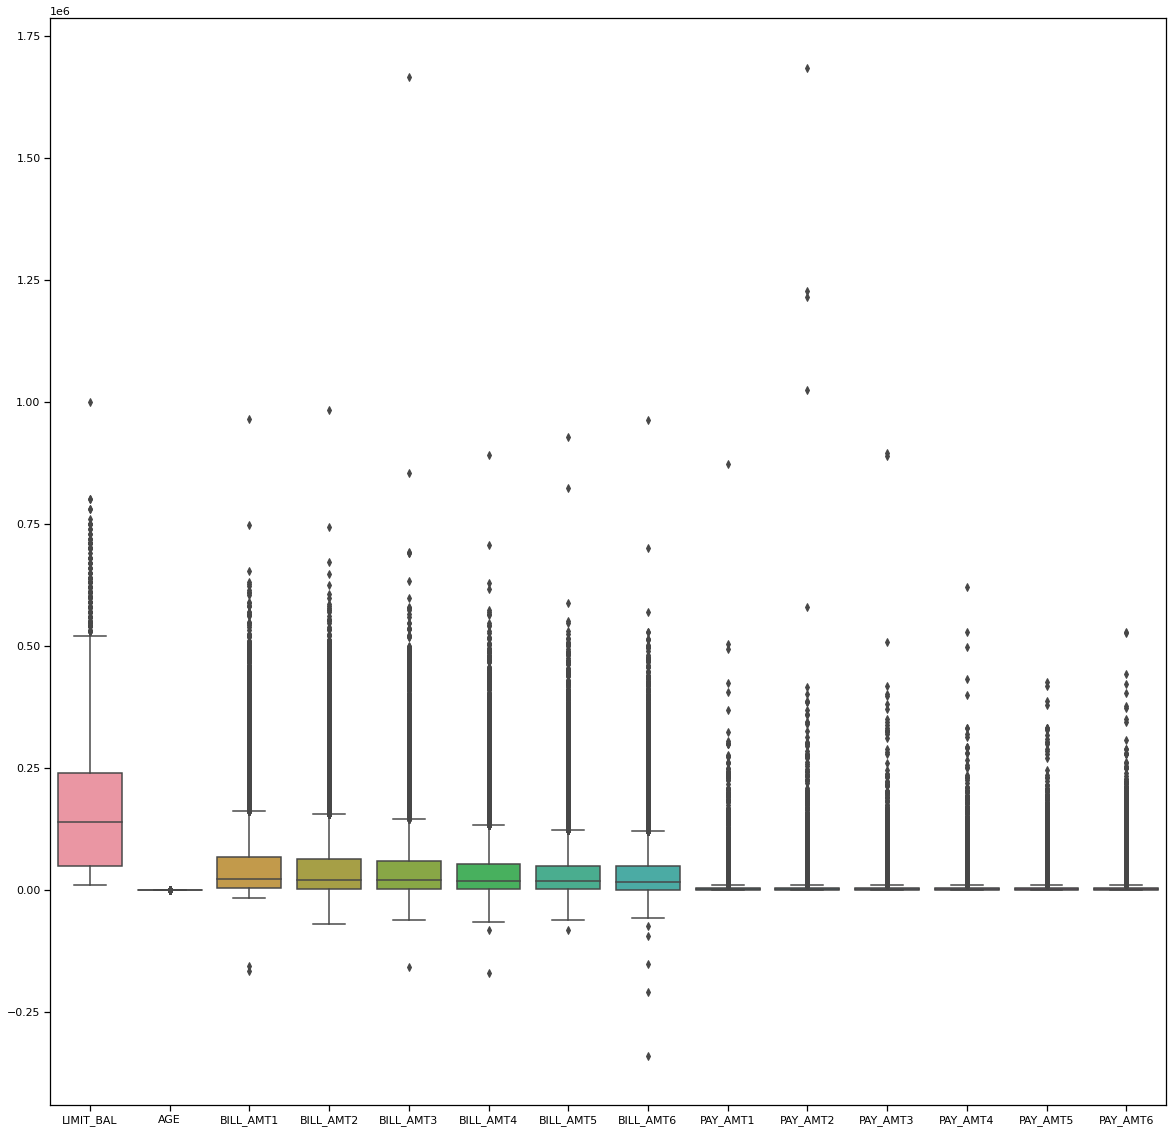

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(data=df_out.select_dtypes(exclude = ['object']))

In [ ]:
cols = df_out.select_dtypes(exclude = ['object']).columns # one or more

Q1 = df_out[cols].quantile(0.25)
Q3 = df_out[cols].quantile(0.75)
IQR = Q3 - Q1

df_out = df_out[~((df_out[cols] < (Q1 - 1.5 * IQR)) |(df_out[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

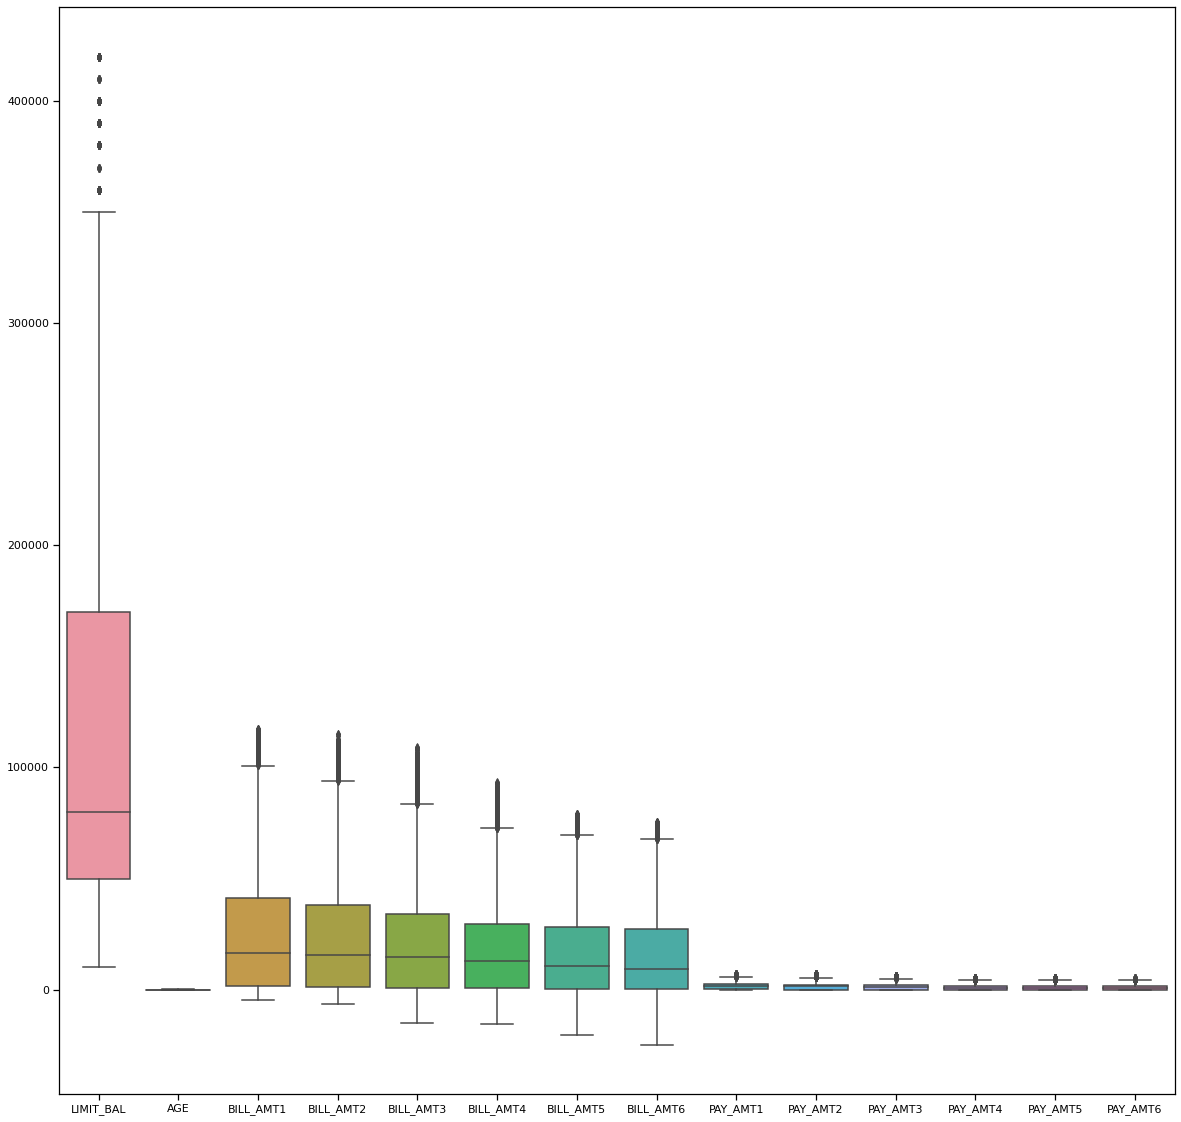

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(data=df_out.select_dtypes(exclude = ['object']))

## Though we continued our analysis on entire data

## Checking Mutual Information

### Mutual Information is helpful to find out the predictive power in independent variables. It is calculated using information gain formula

### MI(Feature, Target) = Entropy(Feature) - Entropy(Feature|Target)

In [ ]:
mi_scores = mutual_info_classif(X, y)

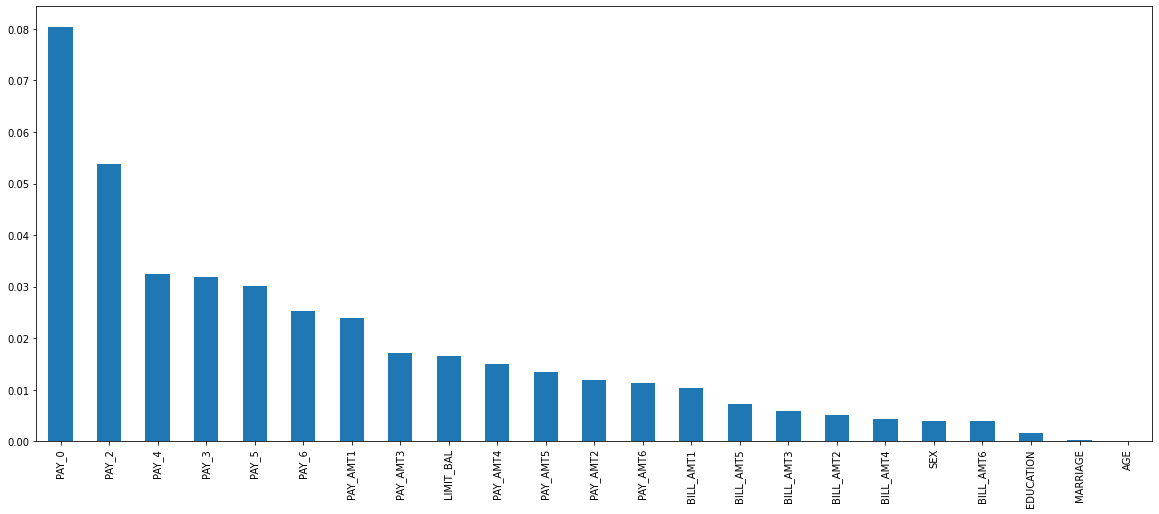

In [ ]:
mutual_information = pd.Series(mi_scores)
mutual_information.index = X.columns
mutual_information.sort_values(ascending = False).plot.bar(figsize=(20, 8))

In [ ]:
iv = IV()
s = StatsSignificance()
ar = AttributeRelevance()

In [ ]:
df1=df.copy()
df1.rename(columns={'default':'label'}, inplace = True)
df1.head()
df1.dtypes

LIMIT_BAL     int64
SEX          object
EDUCATION    object
MARRIAGE     object
AGE           int64
PAY_0        object
PAY_2        object
PAY_3        object
PAY_4        object
PAY_5        object
PAY_6        object
BILL_AMT1     int64
BILL_AMT2     int64
BILL_AMT3     int64
BILL_AMT4     int64
BILL_AMT5     int64
BILL_AMT6     int64
PAY_AMT1      int64
PAY_AMT2      int64
PAY_AMT3      int64
PAY_AMT4      int64
PAY_AMT5      int64
PAY_AMT6      int64
label         int64
dtype: object

In [ ]:
df1['AVG_PAY_AMT'] = (df1['PAY_AMT1'] + df1['PAY_AMT2'] + df1['PAY_AMT3'] + df1['PAY_AMT4'] + df1['PAY_AMT5'] + df1['PAY_AMT6'])/6
df1['AVG_BILL_AMT'] = (df1['BILL_AMT1'] + df1['BILL_AMT2'] + df1['BILL_AMT3'] + df1['BILL_AMT4'] + df1['BILL_AMT5'] + df1['BILL_AMT6'])/6
df1['PAYMENT_TO_BALANCE_RATIO'] = df1['AVG_PAY_AMT']/df1['AVG_BILL_AMT'] 
df1.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label,AVG_PAY_AMT,AVG_BILL_AMT,PAYMENT_TO_BALANCE_RATIO
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,689,0,0,0,0,1,114.833333,1284.000000,0.089434
1,120000,2,2,2,26,-1,2,0,0,0,...,0,1000,1000,1000,0,2000,1,833.333333,2846.166667,0.292791
2,90000,2,2,2,34,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,1836.333333,16942.166667,0.108388
3,50000,2,2,1,37,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,1398.000000,38555.666667,0.036259
4,50000,1,2,1,57,-1,0,-1,0,0,...,2000,36681,10000,9000,689,679,0,9841.500000,18223.166667,0.540054


In [ ]:
df1[df1['PAYMENT_TO_BALANCE_RATIO'].isnull()].head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label,AVG_PAY_AMT,AVG_BILL_AMT,PAYMENT_TO_BALANCE_RATIO
18,360000,2,1,1,49,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0.0,0.0,NaN
19,180000,2,1,2,29,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0.0,0.0,NaN
45,210000,1,1,2,29,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,1,0.0,0.0,NaN
79,240000,2,2,2,44,1,-2,-2,-2,-2,...,0,0,0,0,0,0,1,0.0,0.0,NaN
121,450000,1,1,1,40,1,-2,-2,-2,-2,...,0,0,0,0,0,0,1,0.0,0.0,NaN


In [ ]:

df2 = df1.copy()
feats_dict = {}
for col in [c for c in df2.columns if c != 'label']:
    if is_numeric_dtype(df2[col]):
        feats_dict[col] = ContinuousFeature(df2, col)
    else:
        feats_dict[col] = CategoricalFeature(df2, col)

feats = list(feats_dict.values())

In [ ]:
df_analysis = ar.analyze(feats, iv, s, interpretation=True)
display(df_analysis)

,iv,p-value,effect_size,iv_interpretation,es_interpretation
PAY_0,0.877161,0.000000e+00,0.422925,suspicious,strong
PAY_2,0.548818,0.000000e+00,0.340317,suspicious,medium
PAY_3,0.416046,0.000000e+00,0.295661,strong,medium
PAY_4,0.367266,0.000000e+00,0.279373,strong,medium
PAY_5,0.340194,0.000000e+00,0.270659,strong,medium
PAY_6,0.293309,0.000000e+00,0.250788,medium,medium
AVG_PAY_AMT,0.191907,1.072135e-189,0.175311,medium,weak
LIMIT_BAL,0.175361,9.196206e-192,0.174444,medium,weak
PAY_AMT1,0.143422,4.284602e-152,0.154289,medium,weak
PAY_AMT2,0.128106,4.251707e-133,0.144484,medium,weak


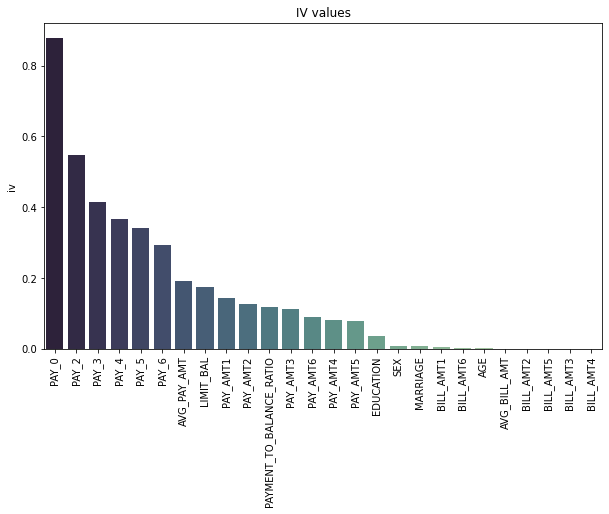

In [ ]:
ar.draw_iv(feats, iv) 

#### Both Information value and mutual information are more or less on the same page in calculating predictor's power

### Categorical variables plots

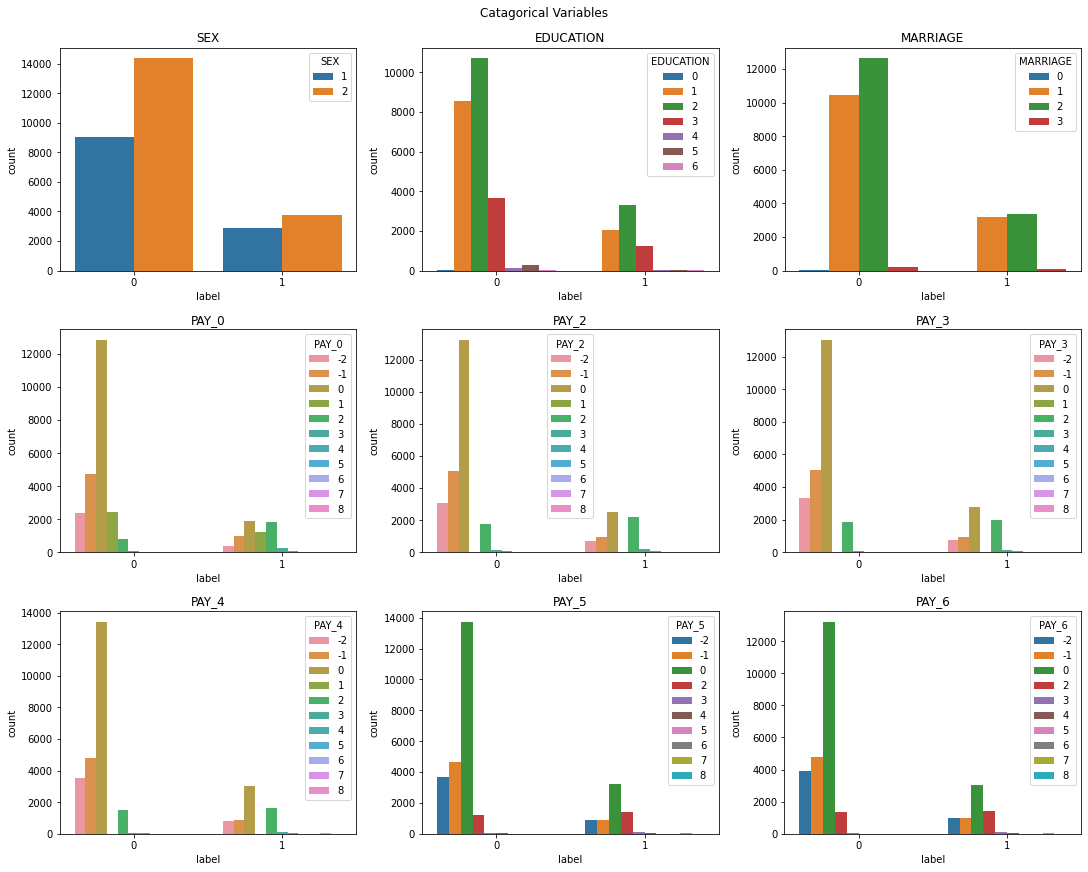

In [ ]:
def axis_adjust(axes, N):
    axes = axes.flat
    for ax in axes[N:]:
        ax.remove()
    return axes[:N]


cat_vars = [var for var in df1.select_dtypes(include = ['object']).columns]
ncols = 3
nrows = int(math.ceil(len(cat_vars)/ncols))
figs, axs = plt.subplots(nrows, ncols, figsize=(15, 4*nrows), constrained_layout=True)
axs = axis_adjust(axs, len(cat_vars))



figs.suptitle('Catagorical Variables')
for ax, var in zip(axs, cat_vars):
    sns.countplot(df1['label'], hue=data[var], ax=ax)
    ax.set_title(var)

## Weight of evidence plot of categorical variables

In [ ]:
categorical_feat = [feats_dict[i] for i in df1.select_dtypes(include = ['object']).columns]

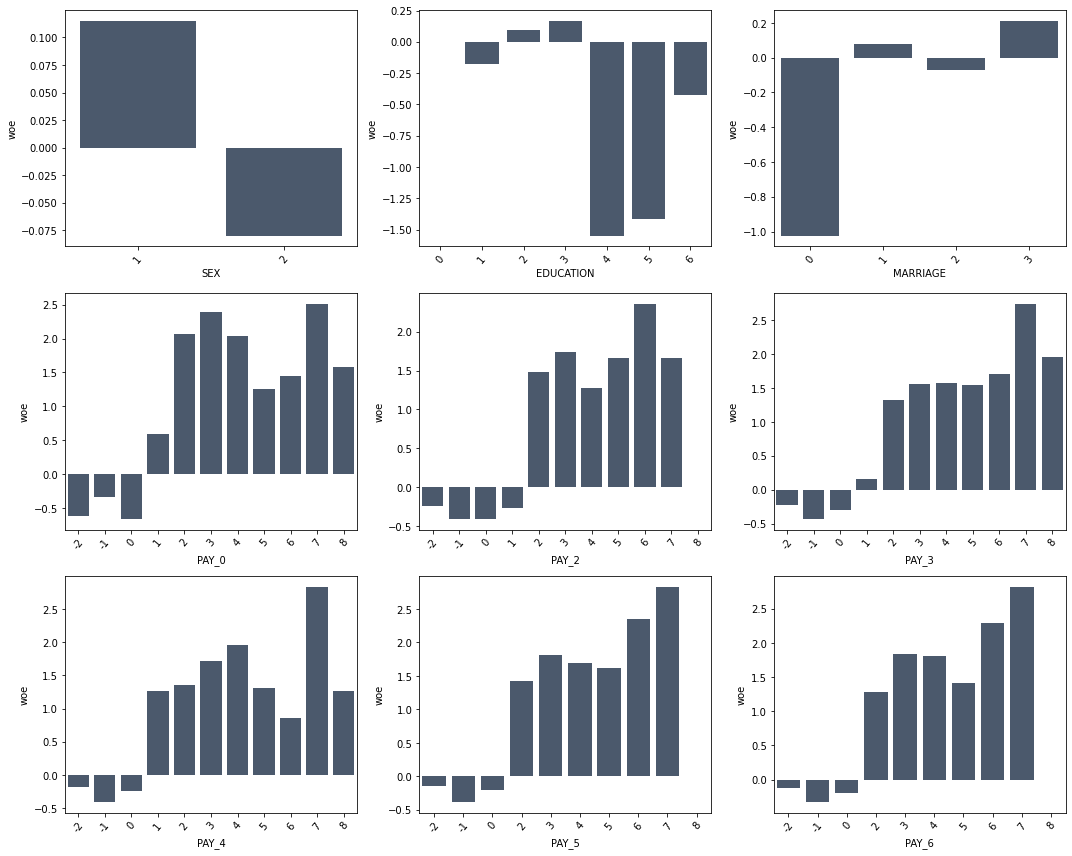

In [ ]:
ar.draw_woe_multiplot(categorical_feat, iv)

## Continuous Feature plots

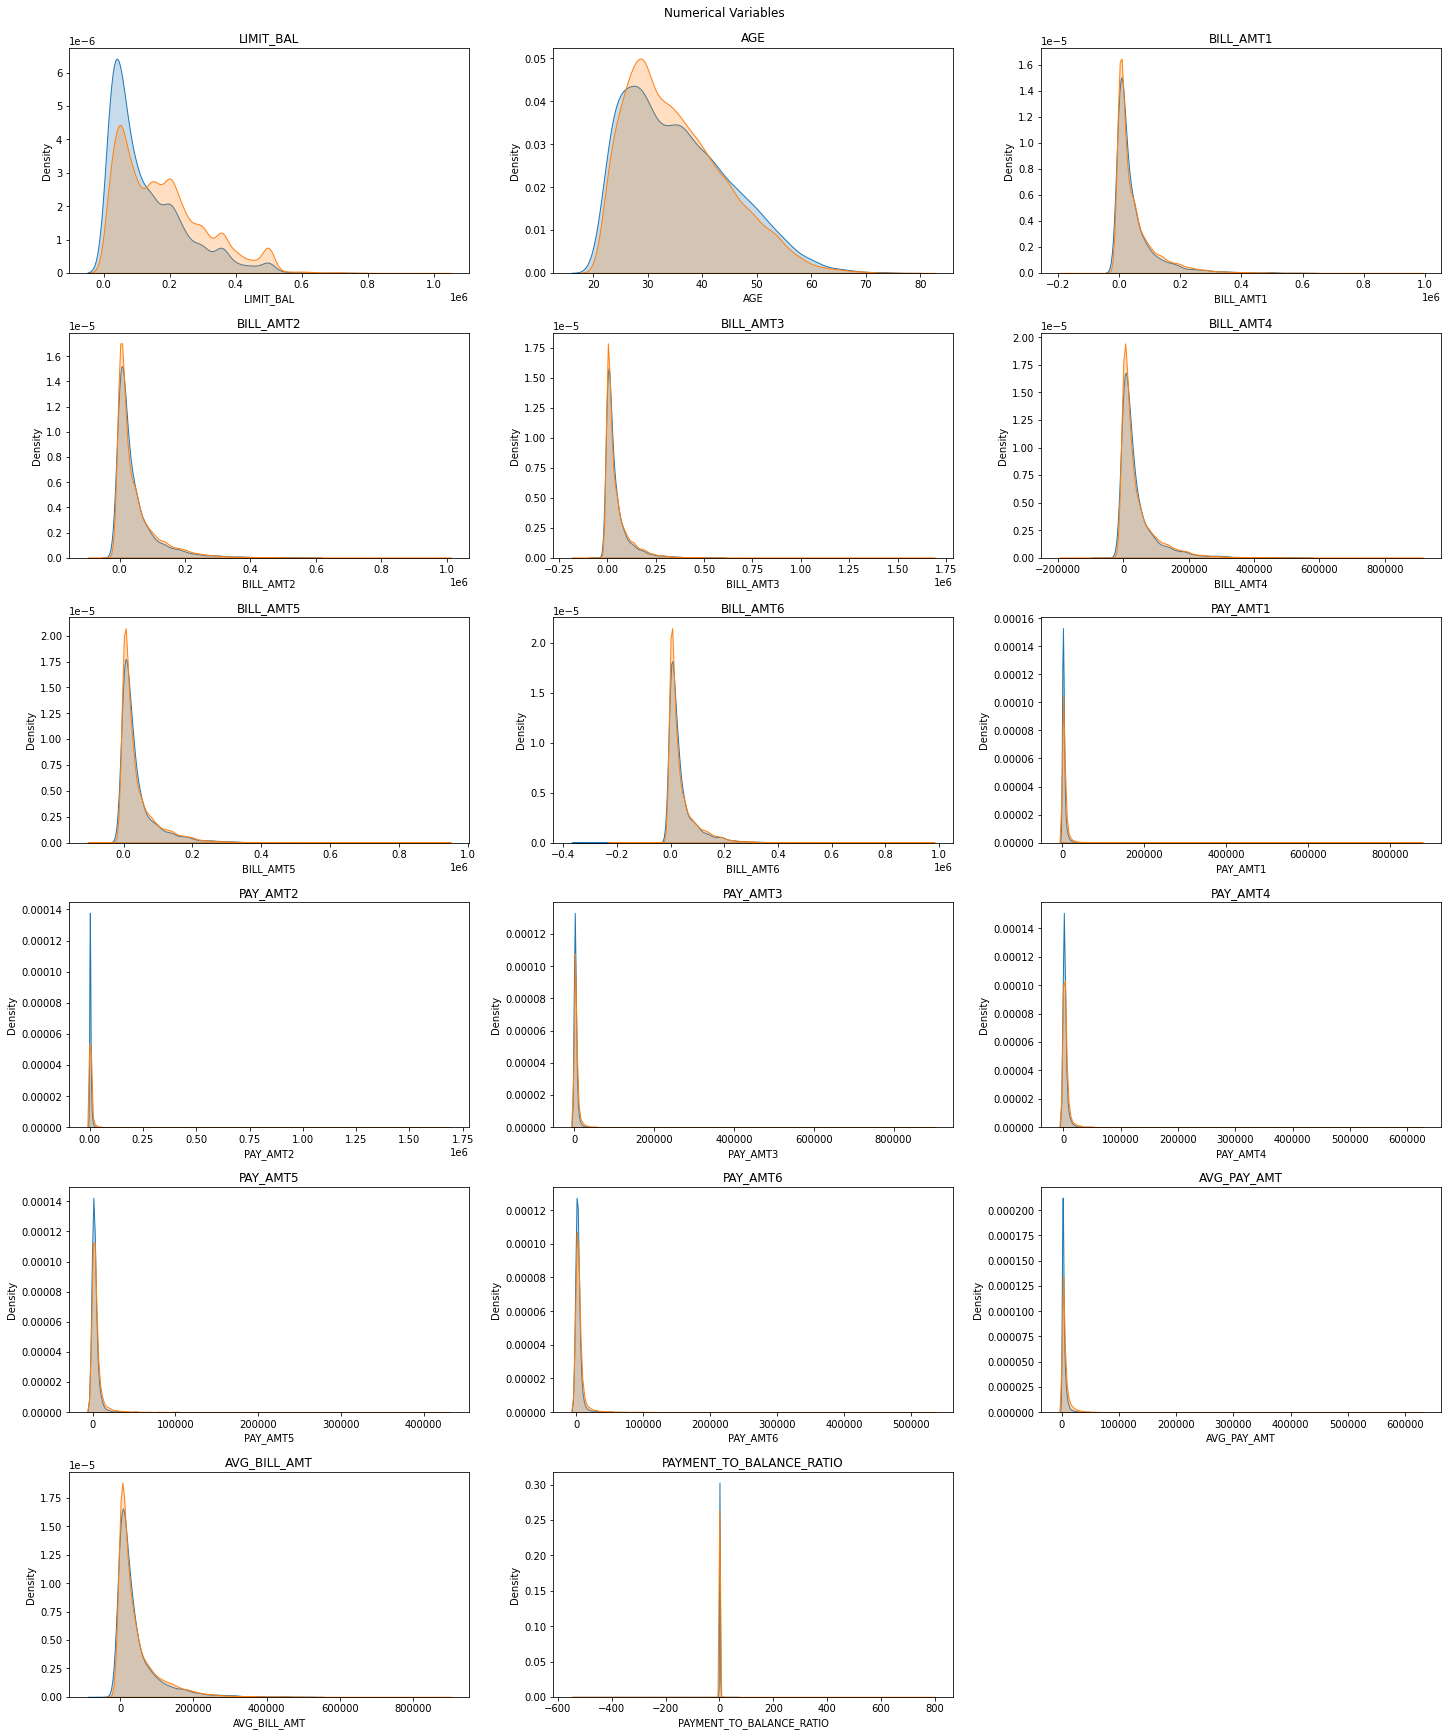

In [ ]:
numerical_vars = [var for var in df1.select_dtypes(exclude = ['object']).columns if var !='label']

ncols = 3
nrows = int(math.ceil(len(numerical_vars)/ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(20, 4*nrows), constrained_layout=True)
axs = axis_adjust(axs, len(numerical_vars))
f.suptitle('Numerical Variables')
for ax, var in zip(axs, numerical_vars):
    for val in df1['label'].unique():
        sns.kdeplot(df1.loc[df1['label'] == val, var], shade=True, ax=ax, label=val);
    ax.set_title(var)

## Weight of evidence plot

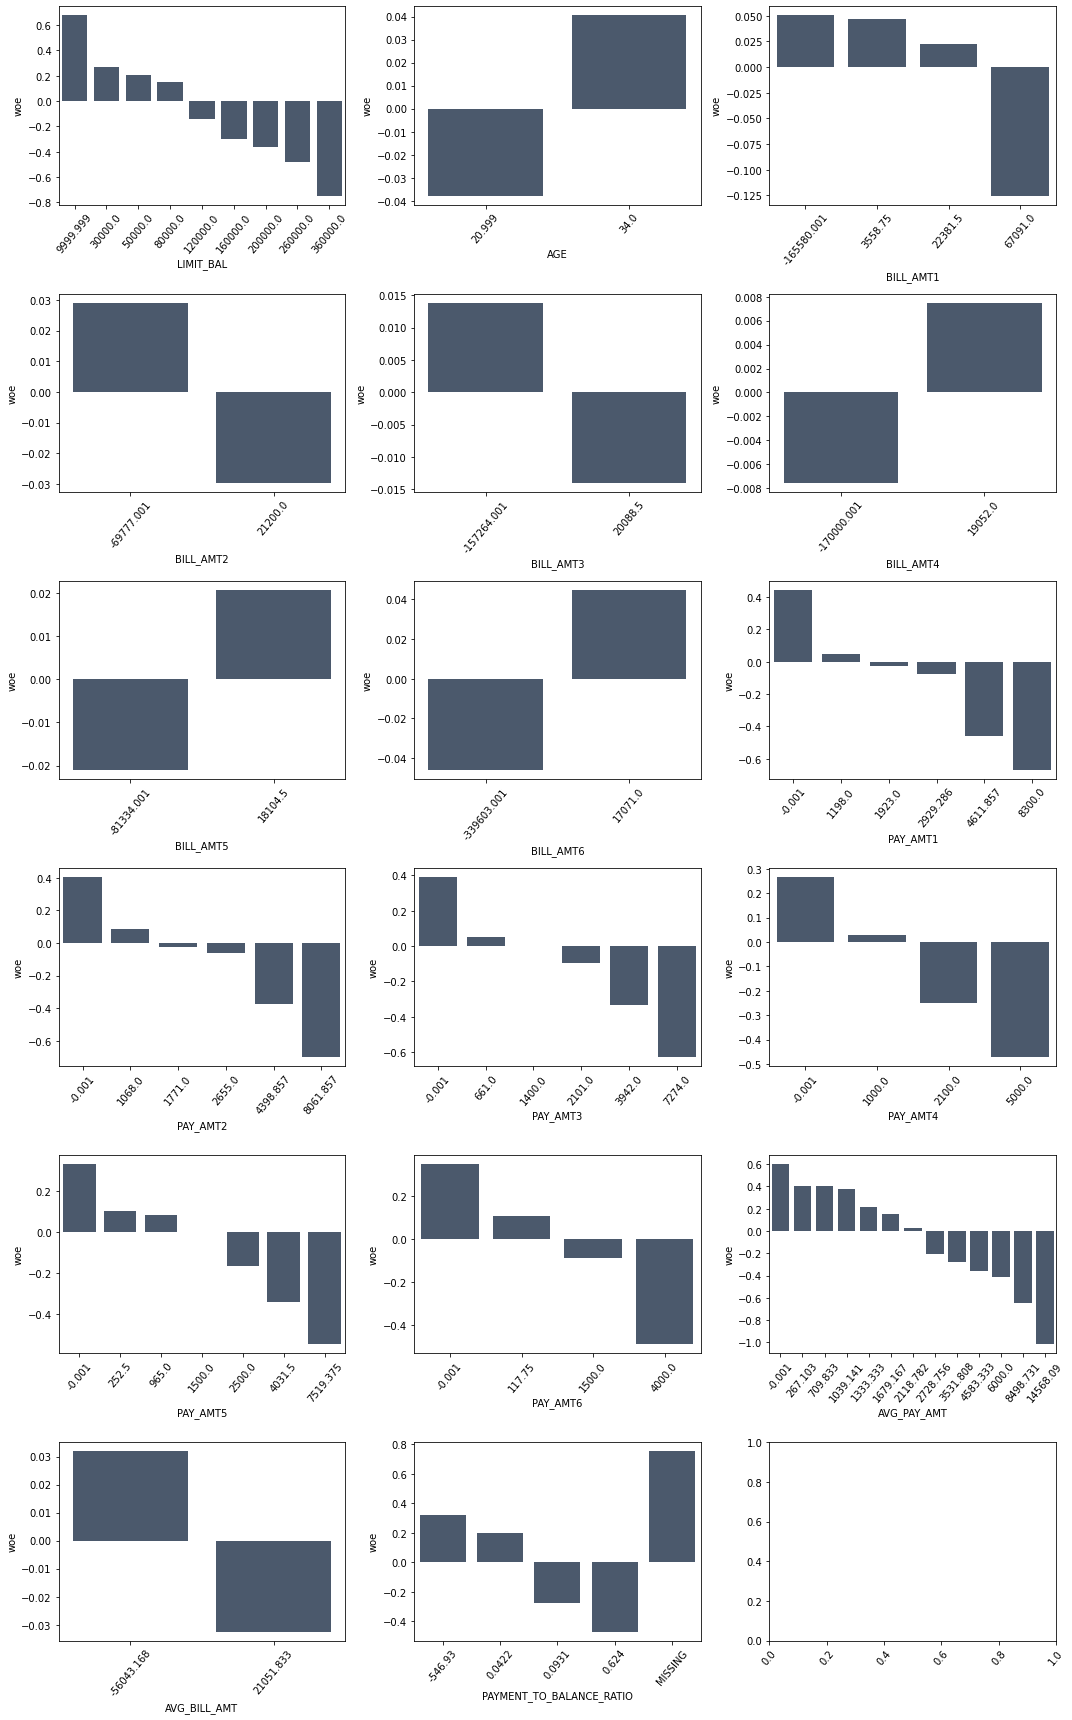

In [ ]:

numerical_feat = [feats_dict[i] for i in df1.select_dtypes(exclude = ['object']).columns if i !='label']
ar.draw_woe_multiplot(numerical_feat, iv)

## Deafaulter's profile :

#### 1. Pay_0 = 3, 7
#### 2. Pay_2 = 7
#### 3. Pay_3 = 7
#### 4. Pay_4 = 7
#### 5. Pay_5 = 6, 7
#### 6. Pay_6 = 6, 7

#### 7. Limit balance <30,000
#### 8. Pay_amt1 < 1200
#### 9. Pay_amt2 < 1000
#### 10. Pay_amt3 < 700
#### 11. Pay_amt4 < 1000
#### 12. Pay_amt5 < 250
#### 13. Pay_amt6 < 100

#### AVG_PAY_AMT < 267

#### PAYMENT_TO_BALANCE_RATIO (AVG_PAY_AMT/AVG_BILL_AMT) = Missing, meaning both AVG_PAY_AMT and AVG_BILL_AMT is 0



## ******************************

#### Based on WOE analysis variables like BILL_AMT(1, 2, 3,...), EDUCATION, AGE, SEX, MARRIAGE fails to separate between default or non default. 

#### Though IV and WOE are notion of linear classifier, we will see these variables turn out to be significant later when we use non linear classifiers like GBM, XGBOOST, Decision Tree , Random Forest etc.

## Model Building

In [ ]:
df_mod = data.copy()
df_mod.drop('ID', axis=1, inplace = True)
df_mod.rename(columns={'default payment next month':'default'}, inplace=True)
y_mod = df_mod['default']
X_mod = df_mod.drop('default', axis=1)
X_mod['AVG_PAY_AMT'] = (X_mod['PAY_AMT1'] + X_mod['PAY_AMT2'] + X_mod['PAY_AMT3'] + X_mod['PAY_AMT4'] + X_mod['PAY_AMT5'] + X_mod['PAY_AMT6'])/6
X_mod['AVG_BILL_AMT'] = (X_mod['BILL_AMT1'] + X_mod['BILL_AMT2'] + X_mod['BILL_AMT3'] + X_mod['BILL_AMT4'] + X_mod['BILL_AMT5'] + X_mod['BILL_AMT6'])/6
# X_mod['PAYMENT_TO_BALANCE_RATIO'] = X_mod['AVG_PAY_AMT']/X_mod['AVG_BILL_AMT'] 
# X_mod['PAYMENT_TO_BALANCE_RATIO'].fillna(-99, inplace=True)
X_mod.isnull().sum()

LIMIT_BAL       0
SEX             0
EDUCATION       0
MARRIAGE        0
AGE             0
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1       0
BILL_AMT2       0
BILL_AMT3       0
BILL_AMT4       0
BILL_AMT5       0
BILL_AMT6       0
PAY_AMT1        0
PAY_AMT2        0
PAY_AMT3        0
PAY_AMT4        0
PAY_AMT5        0
PAY_AMT6        0
AVG_PAY_AMT     0
AVG_BILL_AMT    0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.20, random_state= True)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,test_size=0.5)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24000, 25) (6000, 25) (24000,) (6000,)


### Visualization

### Custom Function for model evaluation

In [ ]:
def plot_feature_importance(importance, names, model_type, var_imp_threshold, ax):
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  data = {'feature_names' : feature_names, 'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  fi_df.sort_values(by=['feature_importance'], ascending = False, inplace = True)
  fi_df1 = fi_df[fi_df['feature_importance']>var_imp_threshold]
  # plt.figure(figsize=(10,8))

  sns.barplot(x=fi_df1['feature_importance'], y=fi_df1['feature_names'], ax=ax)

  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance', fontsize=10)
  plt.ylabel('Feature Importance', fontsize=10)

In [ ]:
def evaluate_model(classifier, classifier_label, test_data, test_label):
  pred = classifier.predict(test_data)
  pred_prob=classifier.predict_proba(test_data)
  confusion_matrix(test_label, pred)
  print("Accuracy Score of :" + classifier_label, accuracy_score(test_label, pred))
  pred_prob_1_df = pd.DataFrame(pred_prob[:, 1], columns=['pred_prob'])
  y_test1 = test_label.copy()
  df1=pd.concat([y_test1, pred_prob_1_df], axis=1)

  fig, ax = plt.subplots(2,2, figsize=(25,15))
  plt.style.use('seaborn-pastel')


  def plot_cm(y_true, y_pred, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels = np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm/cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)

    nrows, ncols = cm.shape

    for i in range(nrows):
      for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]

        if i==j:
          s = cm_sum[i]
          annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
          annot[i, j] = ''
        else:
          annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    cm = pd.DataFrame(cm, index = np.unique(y_true), columns = np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    sns.heatmap(cm, cmap="YlGnBu", annot=annot, fmt='', ax=ax[0, 0])
  
  plot_cm(test_label, pred)

  sns.set_context('notebook', font_scale=1, rc={'lines.linewidth': 1.5})
  sns.kdeplot(df1.loc[(df1['default']==0), 'pred_prob'], color = 'deeppink', shade=True, Label='0', ax=ax[0,1])
  sns.kdeplot(df1.loc[(df1['default']==1), 'pred_prob'], color = 'c', shade=True, Label='1', ax=ax[0,1])


  false_positive_rate1, true_positive_rate1, threshold1= roc_curve(test_label, pred)
  print('roc_auc_scorre : ', roc_auc_score(test_label, pred))
  print('Gini : ', 2 * roc_auc_score(test_label, pred) - 1)
  print('f1-score : ', f1_score(test_label, pred, pos_label=1))


  ax[1,0].plot(false_positive_rate1, true_positive_rate1)
  ax[1,0].plot([0, 1], ls="--")
  ax[1,0].plot([0,0], [1,0], c=".7"), ax[1,0].plot([1,1], c=".7")
  ax[1,0].set_ylabel('True Positive Rate')
  ax[1,0].set_xlabel('False Positive Rate')
  ax[1,0].grid()
  ax[1,0].legend(["AUC=%3f"%roc_auc_score(y_test, pred)])

  plot_feature_importance(importance=classifier.feature_importances_, names = test_data.columns, model_type=classifier_label, var_imp_threshold=0, ax=ax[1,1])


  

## Gradient Boosting Classifier

### Gradient Boosting without hyperparameter training

In [ ]:
gb = GradientBoostingClassifier(max_depth = 3)
gb.fit(X_train, y_train)
print("Train Accuracy : ",accuracy_score(y_train, gb.predict(X_train)))
print("Test Accuracy : ",accuracy_score(y_test, gb.predict(X_test)))

Train Accuracy :  0.8275833333333333
Test Accuracy :  0.8173333333333334


Accuracy Score of :Vanilla GBM 0.8173333333333334
roc_auc_scorre :  0.6504114008158884
Gini :  0.3008228016317769


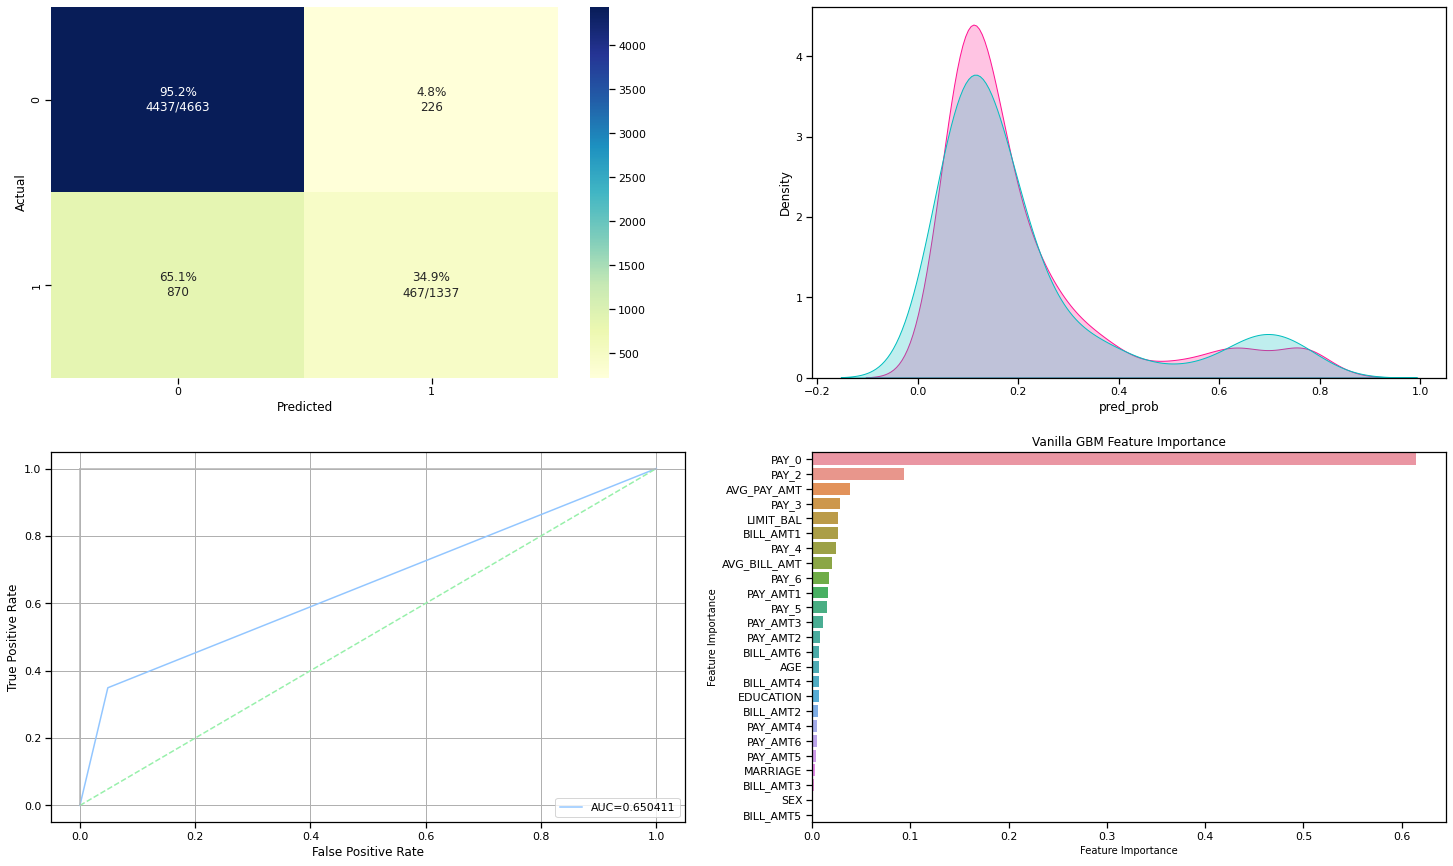

In [ ]:
evaluate_model(gb,'Vanilla GBM', X_test, y_test)

### GBM with Bayes Search

In [ ]:
gb_clf_bo = BayesSearchCV(
    GradientBoostingClassifier(), {'learning_rate': Real(0.1, 0.3), 'max_depth': Integer(1, 6)},
    n_iter = 2,
    random_state=0,
    verbose=1,
    cv=5,
    n_jobs=-1)

In [ ]:
gb_clf_bo.fit(X_mod, y_mod)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=2, n_jobs=-1,
              random_state=0,
              search_spaces={'learning_rate': Real(low=0.1, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=6, prior='uniform', transform='normalize')},
              verbose=1)

In [ ]:
print("Train Accuracy : ",accuracy_score(y_train, gb_clf_bo.predict(X_train)))
print("Test Accuracy : ", accuracy_score(y_test, gb_clf_bo.predict(X_test)))

Train Accuracy :  0.84175
Test Accuracy :  0.8388333333333333


Accuracy Score of :gbm bayes search 0.8388333333333333
roc_auc_scorre :  0.6895844223795243
Gini :  0.37916884475904866
f1-score :  0.5375418460066954


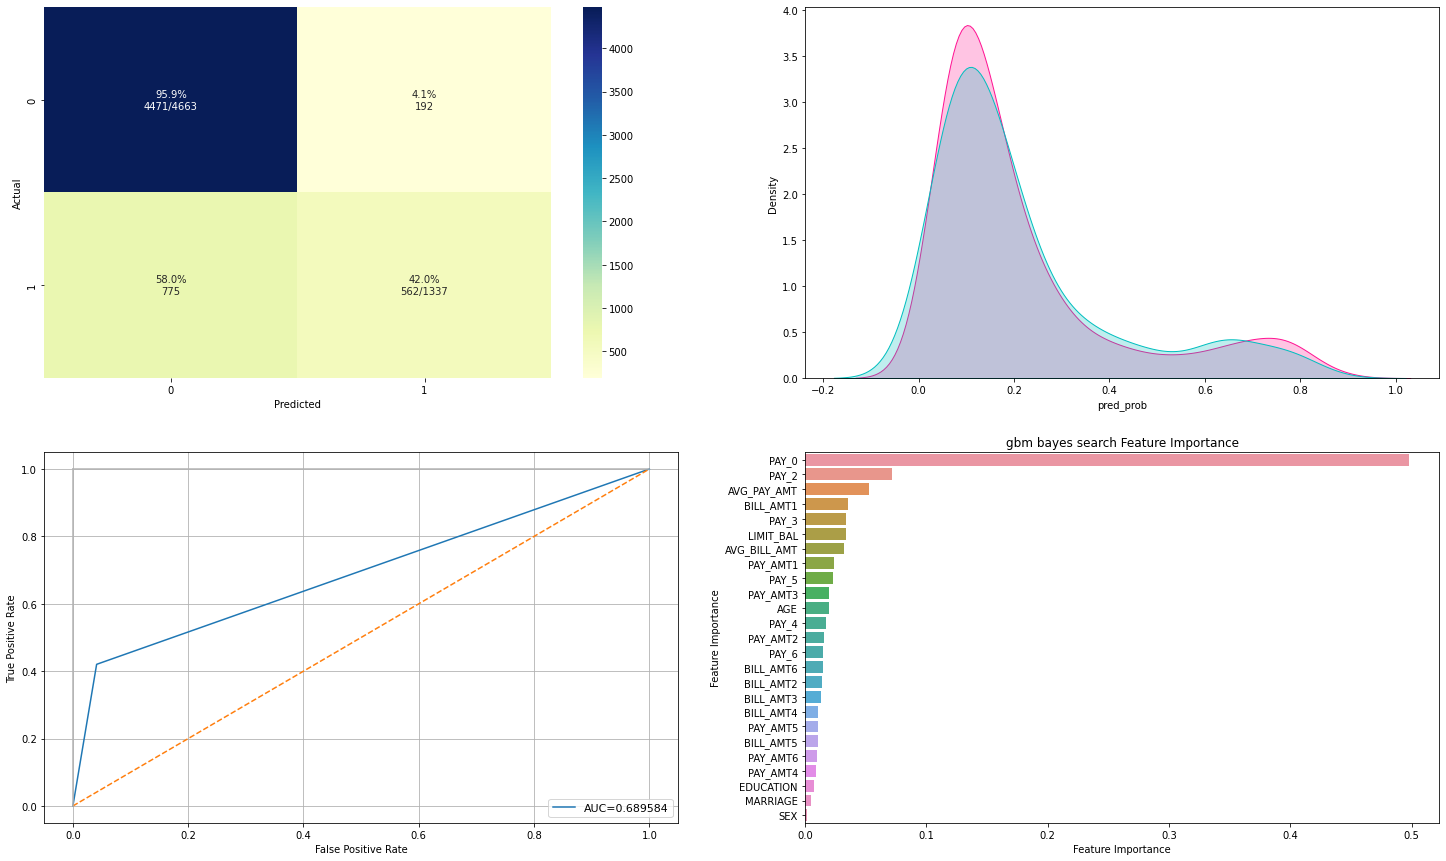

In [ ]:
evaluate_model(gb_clf_bo.best_estimator_,'gbm bayes search', X_test, y_test)

## Extreme Gradient Boosting

### XGB with Bayes Search using Hyperopt module

In [ ]:
space={'max_depth': hp.quniform("max_depth", 1, 32, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1), # controls over fitting
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7783333333333333
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.7771666666666667
SCORE:
0.777

In [ ]:
best_hyperparams['max_depth']=int(best_hyperparams['max_depth'])
print(best_hyperparams)

{'colsample_bytree': 0.7065388040269421, 'gamma': 7.418876301371868, 'max_depth': 14.0, 'min_child_weight': 2.0, 'reg_alpha': 178.0, 'reg_lambda': 0.49812797954485066}


In [ ]:
xgb_clf = xgb.XGBClassifier(**best_hyperparams)

In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7065388040269421, gamma=7.418876301371868,
              max_depth=14, min_child_weight=2.0, reg_alpha=178.0,
              reg_lambda=0.49812797954485066)

In [ ]:
accuracy_score(y_test, xgb_clf.predict(X_test))

0.8185

Accuracy Score of :XGB bayes search 0.8185
roc_auc_scorre :  0.6383582559499016
Gini :  0.2767165118998032
f1-score :  0.4348728593668916


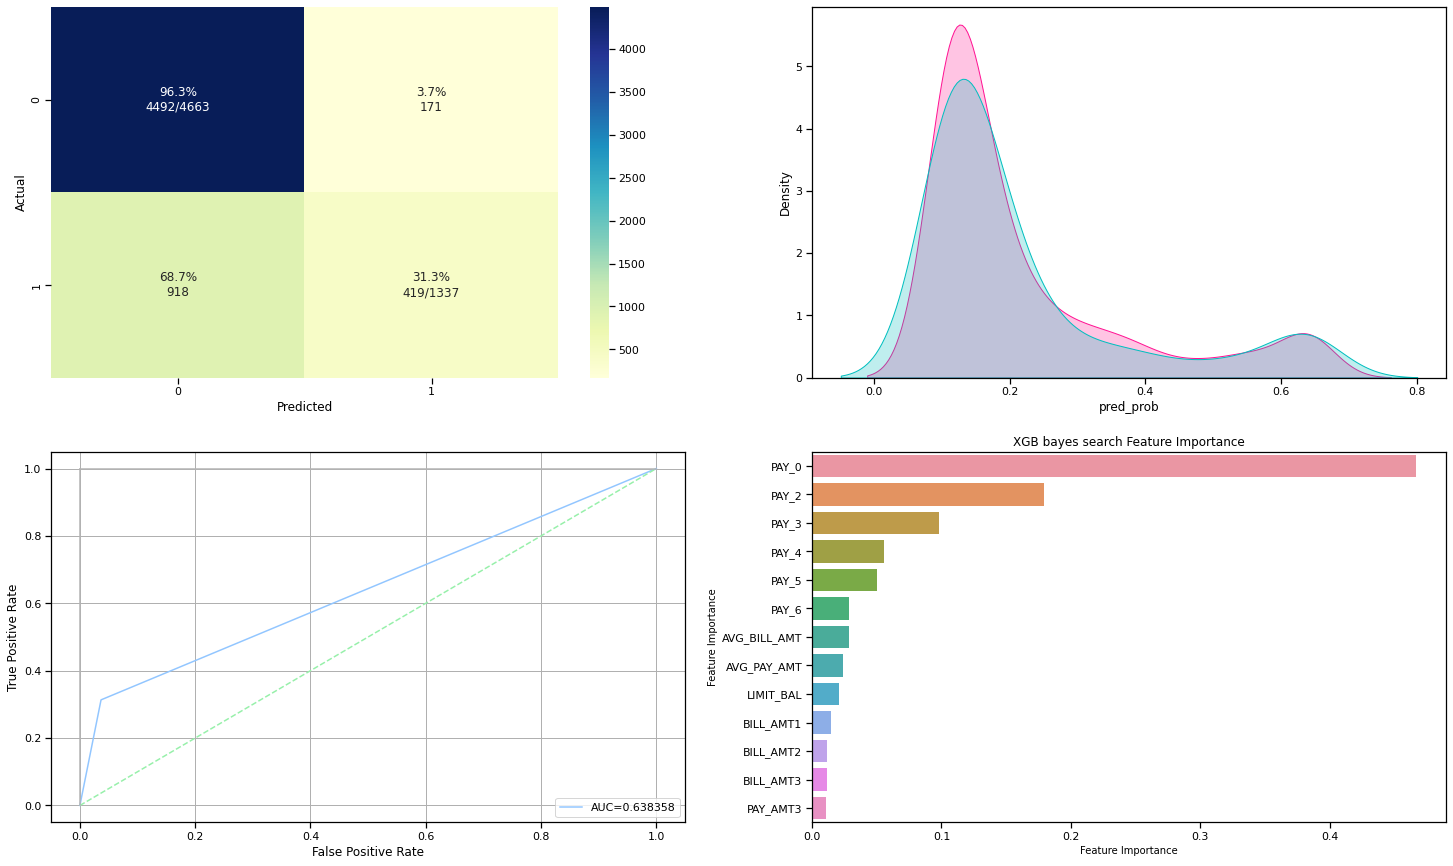

In [ ]:
evaluate_model(xgb_clf,'XGB bayes search', X_test, y_test)

## Neural Network

In [ ]:
checkpoint_path = 'best_nn.hdf5'

In [ ]:
n_features = X_train.shape[1]
model = Sequential()
model.add(Dense(50, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(30, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

weights_save = ModelCheckpoint(checkpoint_path,save_best_only=True, monitor='val_accuracy', mode='max')
# compile the model
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model


In [ ]:
history_nn = model.fit(X_train, 
          y_train, 
          epochs=50, 
          batch_size=32, 
          verbose=1, 
          validation_data=(X_test, y_test),
          shuffle = False, 
          callbacks=[weights_save])
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Epoch 1/50
750/750 [==============================] - 2s 3ms/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 1.1543 - val_accuracy: 0.7770
Epoch 2/50
750/750 [==============================] - 2s 2ms/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 1.1486 - val_accuracy: 0.7770
Epoch 3/50
750/750 [==============================] - 2s 2ms/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 1.1490 - val_accuracy: 0.7770
Epoch 4/50
750/750 [==============================] - 2s 2ms/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 1.1494 - val_accuracy: 0.7770
Epoch 5/50
750/750 [==============================] - 2s 2ms/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 1.1498 - val_accuracy: 0.7770
Epoch 6/50
750/750 [==============================] - 2s 2ms/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 1.1500 - val_accuracy: 0.7770
Epoch 7/50
750/750 [==============================] - 2s 2ms/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 1.1499 - val_accuracy: 0.7770
Epoch 

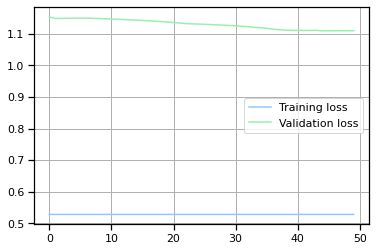

In [ ]:
plt.plot(history_nn.history['loss'], label='Training loss')
plt.plot(history_nn.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.grid()
plt.show()

### Neural network is not performing well as compared to other models so far.
### We can try Bayesian Optimization on this to fine tune further on number of layers, nodes, activation function, optimizers, learning rate, epochs, batch size, dropout percentage etc.
### We can also try different architechture like functional or subclassing instead of our current sequential architecture. Functional architecture may turn out to be a better one as it is capable of learning both deep and simple pattern.

## Light GBM Model

In [ ]:
X_train_lgb=X_train.astype({'SEX': 'category',
'EDUCATION': 'category',
'MARRIAGE': 'category',
'PAY_0': 'category',
'PAY_2': 'category',
'PAY_3': 'category',
'PAY_4': 'category',
'PAY_5': 'category',
'PAY_6': 'category',
})

X_test_lgb=X_test.astype({'SEX': 'category',
'EDUCATION': 'category',
'MARRIAGE': 'category',
'PAY_0': 'category',
'PAY_2': 'category',
'PAY_3': 'category',
'PAY_4': 'category',
'PAY_5': 'category',
'PAY_6': 'category',
})


In [ ]:
train_lgb = lgb.Dataset(X_train_lgb, label=y_train, categorical_feature='auto')
test_lgb = lgb.Dataset(X_test_lgb, label=y_test, categorical_feature='auto')

In [ ]:
space4lgb = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.5),
    'num_leaves': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('num_leaves', 4.5, 1, 1), 2)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'feature_fraction_bynode': hp.uniform('feature_fraction_bynode', 0.5, 1),
    'min_data_in_leaf': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('min_data_in_leaf', 4.5, 1, 1), 3)),
    'max_cat_to_onehot': pyll.scope.int(hp.quniform('max_cat_to_onehot', 4, 10, 1)),
    'lambda_l1': hp.lognormal('lambda_l1', 3, 2),
    'lambda_l2': hp.lognormal('lambda_l2', 3, 2),
    'max_bin': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('max_bin', 6.5, 1, 1), 10)), 
}
pyll.stochastic.sample(space4lgb)

{'bagging_fraction': 0.9968368558213068,
 'feature_fraction': 0.7273999986708826,
 'feature_fraction_bynode': 0.8454556066780453,
 'lambda_l1': 511.6503294827907,
 'lambda_l2': 61.81246187055919,
 'learning_rate': 0.0869764871578626,
 'max_bin': 145,
 'max_cat_to_onehot': 4,
 'min_data_in_leaf': 43,
 'num_leaves': 228}

In [ ]:
default_params = {'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'num_boost_round': 100,
                  'metric': 'auc',
                  'categorical_feature': 'auto',
                  'valid_sets': None,
                  'bagging_seed': 100,
                  'verbose': 0,
                  'seed': 100
                  }

In [ ]:
def hyperopt_lgb_train(params):
    params = {**default_params, **params}
    num_boost_round = params.pop('num_boost_round')
    valid_sets = params.pop('valid_sets')
    bst = lgb.train(params, train_lgb, num_boost_round, valid_sets = valid_sets)
    return_dict = {'loss': -roc_auc_score(y_test, bst.predict(X_test_lgb)),
                   'status': STATUS_OK
                   }
    print(return_dict)
    return return_dict

In [ ]:
hyperopt_lgb_train(pyll.stochastic.sample(space4lgb))

{'loss': -0.7714392059195138, 'status': 'ok'}


{'loss': -0.7714392059195138, 'status': 'ok'}

In [ ]:
trials = Trials()
best = fmin(hyperopt_lgb_train, space4lgb, algo=tpe.suggest, max_evals=100, trials=trials)

{'loss': -0.7828629429052948, 'status': 'ok'}
{'loss': -0.7861006882584795, 'status': 'ok'}
{'loss': -0.770052952707312, 'status': 'ok'}
{'loss': -0.7802586154213592, 'status': 'ok'}
{'loss': -0.7817148830422536, 'status': 'ok'}
{'loss': -0.7824141449315904, 'status': 'ok'}
{'loss': -0.7753411658577984, 'status': 'ok'}
{'loss': -0.7810307789114996, 'status': 'ok'}
{'loss': -0.771701298803371, 'status': 'ok'}
{'loss': -0.7806634639151511, 'status': 'ok'}
{'loss': -0.775778254663497, 'status': 'ok'}
{'loss': -0.77873489978476, 'status': 'ok'}
{'loss': -0.7777269489388847, 'status': 'ok'}
{'loss': -0.7766707980247115, 'status': 'ok'}
{'loss': -0.7751691373278491, 'status': 'ok'}
{'loss': -0.7539831622164075, 'status': 'ok'}
{'loss': -0.6822519970146435, 'status': 'ok'}
{'loss': -0.7673569568738511, 'status': 'ok'}
{'loss': -0.7753108503406326, 'status': 'ok'}
{'loss': -0.781343558056862, 'status': 'ok'}
{'loss': -0.7801242005886342, 'status': 'ok'}
{'loss': -0.7843855357449621, 'status': 

In [ ]:
best

{'bagging_fraction': 0.5809649508013582,
 'feature_fraction': 0.5808234090683304,
 'feature_fraction_bynode': 0.5318594925924515,
 'lambda_l1': 0.09014769443004526,
 'lambda_l2': 0.29217791512986757,
 'learning_rate': 0.03661156572315463,
 'max_bin': 1868.0,
 'max_cat_to_onehot': 7.0,
 'min_data_in_leaf': 84.0,
 'num_leaves': 38.0}

In [ ]:
space_eval(space4lgb, best)

{'bagging_fraction': 0.5809649508013582,
 'feature_fraction': 0.5808234090683304,
 'feature_fraction_bynode': 0.5318594925924515,
 'lambda_l1': 0.09014769443004526,
 'lambda_l2': 0.29217791512986757,
 'learning_rate': 0.03661156572315463,
 'max_bin': 1868,
 'max_cat_to_onehot': 7,
 'min_data_in_leaf': 84,
 'num_leaves': 38}

In [ ]:
default_params = {'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'num_boost_round': 100,
                  'metric': 'auc',
                  'categorical_feature': 'auto',
                  'valid_sets': None,
                  'bagging_seed': 100,
                  'verbose': 0,
                  'seed': 100
                  }
params = {**default_params, **space_eval(space4lgb, best)}
del params['valid_sets'], params['num_boost_round']
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'auc',
 'categorical_feature': 'auto',
 'bagging_seed': 100,
 'verbose': 0,
 'seed': 100,
 'bagging_fraction': 0.5809649508013582,
 'feature_fraction': 0.5808234090683304,
 'feature_fraction_bynode': 0.5318594925924515,
 'lambda_l1': 0.09014769443004526,
 'lambda_l2': 0.29217791512986757,
 'learning_rate': 0.03661156572315463,
 'max_bin': 1868,
 'max_cat_to_onehot': 7,
 'min_data_in_leaf': 84,
 'num_leaves': 38}

In [ ]:
lgbm=lgb.LGBMClassifier(**params)

In [ ]:
lgbm.fit(X_train_lgb, y_train)

LGBMClassifier(bagging_fraction=0.5809649508013582, bagging_seed=100,
               categorical_feature='auto', feature_fraction=0.5808234090683304,
               feature_fraction_bynode=0.5318594925924515,
               lambda_l1=0.09014769443004526, lambda_l2=0.29217791512986757,
               learning_rate=0.03661156572315463, max_bin=1868,
               max_cat_to_onehot=7, metric='auc', min_data_in_leaf=84,
               num_leaves=38, objective='binary', seed=100, verbose=0)

Accuracy Score of :Light GBM 0.817
roc_auc_scorre :  0.6477962463615363
Gini :  0.29559249272307264
f1-score :  0.4548162859980139


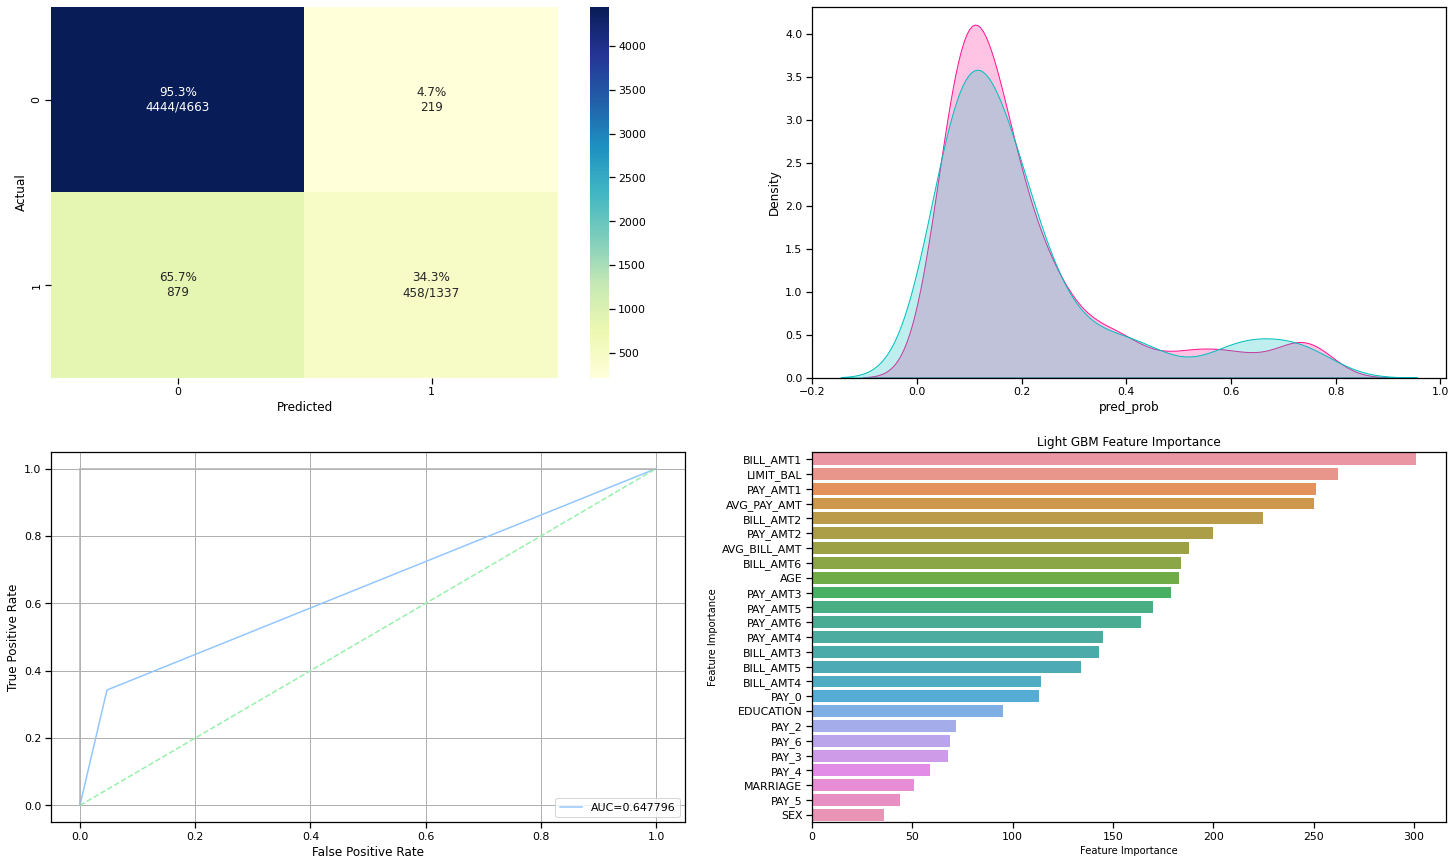

In [ ]:
evaluate_model(lgbm, 'Light GBM', X_test_lgb, y_test)

# 1. GBM Bayesian Search is slightly doing better than other models. though their classification power is not that great. False positive is higher. overall accuracy is high as non-defualt are in majority and models fail to capture pattern to discriminate between the two.
  ### a. as a remedy we can try to create more features.
  ### b. payment and balance variables (though week predictors) have positively skewed distribution. we need take some transformation (log or square) to check if their predicting power has improved. 

# 2. Due to time constraint I couldn't try Logistic regression, it would require data manipulation like creating dummies (though it is always recommended to create dummies, they are good in interpretetion and can easily captured by models), multicolinearity removal, etc.

# 3. We can also try stacking or blending method to use differnt models to create one single model.

# Explainer

### 1. I have used SHAP package for calculating shapley values.
### 2. Shapley value is based on game theory
### 3. It can give output in both Global and local level (individual observation).
### 4. It can help us visualize the contribution of each variable in predicting a observation as 1/0

In [ ]:
explainer = shap.TreeExplainer(model=gb_clf_bo.best_estimator_
                              #  data=None,
                              #  model_output='raw',
                              #  feature_perturbation='tree_path_dependent'
                               )

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
print(f'Shape of test dataset: {X_test.shape}')
print(f'Type of shap_values: {type(shap_values)}. Length of the list: {len(shap_values)}')
print(f'Shape of shap_values: {np.array(shap_values).shape}')

Shape of test dataset: (6000, 25)
Type of shap_values: <class 'numpy.ndarray'>. Length of the list: 6000
Shape of shap_values: (6000, 25)


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[2], features=X_test.columns)

### One single observation and variables' contribution : The variables in red are pushing the observation towards default=1

#### -1.59 is the final log(odds) value, Exp(log(odds))/(1+exp(log(odds)) gives probability of default

In [ ]:
z=gb_clf_bo.best_estimator_.predict_proba(X_test)
z[2]

array([0.83025948, 0.16974052])

0.16 is the probability of default=1

In [ ]:
y_test.head(3).values[2]

0

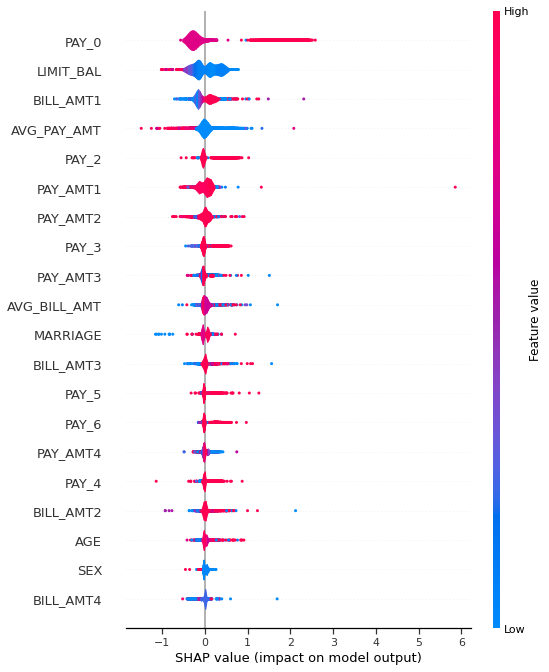

In [ ]:
shap.summary_plot(shap_values, features=X_test, plot_type="violin")

# A few observations from above plot

### 1. Pay_0 higher values pushing towards default=1
### 2. Limit_bal low values pushing towards default=1
### 3. low average_payment pushing towards default=1
### 4. higher age pushing towards default=1
### 5. Bill_amt2 higher values pushing towards default=1


In [ ]:
shap_values[0].shape

(25,)